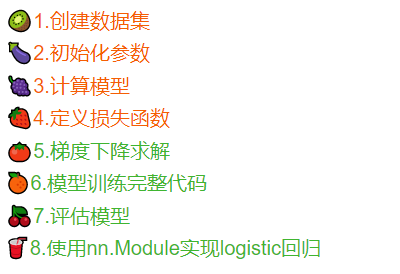

logistic回归虽然名字是回归，但实际上是一个分类算法，主要处理二分类问题。

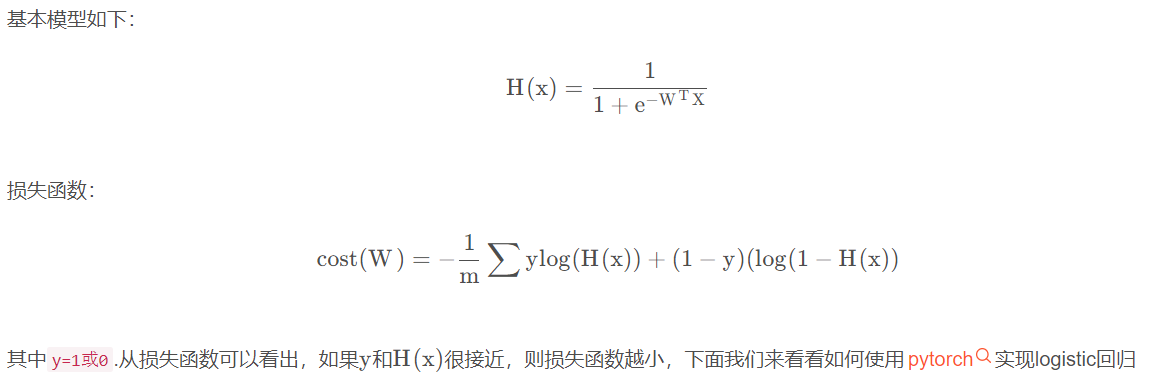

# 1.创建数据集

In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F #神经网络内置函数
import torch.optim as optim


In [16]:
# 设计随机数，为了结果的可复现性
torch.manual_seed(1)

In [17]:
x = torch.tensor([[1, 2], [2, 3], [3, 1], [4, 3], [5, 3], [6, 2]],dtype=torch.float)
y = torch.tensor([[0], [0], [0], [1], [1], [1]],dtype=torch.float)


考虑以下分类问题：给定每个学生观看讲座和在代码实验室工作的小时数，预测学生是否通过了课程。例如，第一个（索引0）学生看了一个小时的讲座，在实验课上花了两个小时（[1,2]），结果课程不及格（[0]）。

# 2.初始化参数

In [18]:
W = torch.zeros((2, 1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)


# 3.计算模型

In [19]:
h = 1 / (1 + torch.exp(-(torch.matmul(x,W) + b)))
h  

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<MulBackward0>)

In [20]:
h = torch.sigmoid(torch.matmul(x,W)+b)
h #在torch中，我们也可以使用torch.sigmoid()函数得到一样的结果

tensor([[0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000],
        [0.5000]], grad_fn=<SigmoidBackward0>)

# 4.定义损失函数

In [21]:
def loss_fun(y,h):
    return (-(y * torch.log(h) + 
           (1 - y) * torch.log(1 - h))).mean()


In [22]:
#在nn中，包含许多内置函数，其中包含了计算交叉熵函数F.binary_cross_entropy,可以实现与上述代码一样的结果

F.binary_cross_entropy(h, y)

tensor(0.6931, grad_fn=<BinaryCrossEntropyBackward0>)

# 5.梯度下降求解

In [23]:
#optim中包含了常见的优化算法，包括Adam,SGD等，这里我们还是和之前一样使用随机梯度下降，后续会介绍其他的优化算法
optimizer = optim.SGD([W, b], lr=0.05)


# 6.模型训练

In [24]:
nb_epochs = 1000
for epoch in range(nb_epochs + 1):
    #计算h
    h = torch.sigmoid(x.matmul(W) + b)
    #计算损失函数
    cost = -(y * torch.log(h) + 
             (1 - y) * torch.log(1 - h)).mean()
    # 梯度下降优化
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print('Epoch {:4d}/{} Cost: {:.6f}'.format(
            epoch, nb_epochs, cost.item()
        ))


Epoch    0/1000 Cost: 0.693147
Epoch  100/1000 Cost: 0.467105
Epoch  200/1000 Cost: 0.414417
Epoch  300/1000 Cost: 0.378999
Epoch  400/1000 Cost: 0.349569
Epoch  500/1000 Cost: 0.323939
Epoch  600/1000 Cost: 0.301350
Epoch  700/1000 Cost: 0.281350
Epoch  800/1000 Cost: 0.263580
Epoch  900/1000 Cost: 0.247739
Epoch 1000/1000 Cost: 0.233564


# 7.评估模型

In [25]:
#在我们完成模型的训练后，我们想检查我们的模型是否适合训练集。
# 首先根据估计的参数结果计算h
h = torch.sigmoid(x.matmul(W) + b)
print(h)

tensor([[0.0723],
        [0.1927],
        [0.4648],
        [0.7152],
        [0.8906],
        [0.9655]], grad_fn=<SigmoidBackward0>)


In [26]:
# 大于0.5的为True，小于0.5的为False
prediction = h >= torch.FloatTensor([0.5])
print(prediction)

tensor([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])


In [27]:
# 注意在python中0=False，1=True
print(prediction)
print(y)


tensor([[False],
        [False],
        [False],
        [ True],
        [ True],
        [ True]])
tensor([[0.],
        [0.],
        [0.],
        [1.],
        [1.],
        [1.]])


In [28]:
# 计算预测值和真实值相同的个数
correct_prediction = prediction.float() == y
print(correct_prediction)


tensor([[True],
        [True],
        [True],
        [True],
        [True],
        [True]])


In [29]:
# 计算预测正确的数量占总数量的比例
accuracy = correct_prediction.sum().item() / len(correct_prediction)
print('The model has an accuracy of {:2.2f}% for the training set.'.format(accuracy * 100))


The model has an accuracy of 100.00% for the training set.


# 8.使用nn.Module实现logistic回归

上面为了演示logistic回归的具体实现原理，我们是使用一步一步实现的，但是在实际中，往往会使用nn.module或者nn实现，下面是实现logistic的简化代码。

In [30]:
'''
定义二元分类器
'''
class BinaryClassifier(nn.Module):
    def __init__(self):
        super().__init__()
        self.linear = nn.Linear(2, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        return self.sigmoid(self.linear(x))
model = BinaryClassifier()

'''
定义随机梯度下降
'''
optimizer = optim.SGD(model.parameters(), lr=0.7)

'''
模型训练
'''
nb_epochs = 100
for epoch in range(nb_epochs + 1):

   #计算h
    hypothesis = model(x)

    # 计算损失函数
    cost = F.binary_cross_entropy(hypothesis, y)

    # 梯度下降
    optimizer.zero_grad()
    cost.backward()
    optimizer.step()
    
    # 输出结果
    if epoch % 10 == 0:
        prediction = hypothesis >= torch.FloatTensor([0.5])
        correct_prediction = prediction.float() == y
        accuracy = correct_prediction.sum().item() / len(correct_prediction)
        print('Epoch {:4d}/{} Cost: {:.6f} Accuracy {:2.2f}%'.format(
            epoch, nb_epochs, cost.item(), accuracy * 100,
        ))


Epoch    0/100 Cost: 0.539713 Accuracy 83.33%
Epoch   10/100 Cost: 0.488187 Accuracy 66.67%
Epoch   20/100 Cost: 0.398818 Accuracy 66.67%
Epoch   30/100 Cost: 0.344865 Accuracy 83.33%
Epoch   40/100 Cost: 0.305266 Accuracy 83.33%
Epoch   50/100 Cost: 0.275640 Accuracy 83.33%
Epoch   60/100 Cost: 0.251937 Accuracy 100.00%
Epoch   70/100 Cost: 0.231838 Accuracy 100.00%
Epoch   80/100 Cost: 0.214554 Accuracy 100.00%
Epoch   90/100 Cost: 0.199574 Accuracy 100.00%
Epoch  100/100 Cost: 0.186494 Accuracy 100.00%
